# Interactions

In [1]:
import igraph as ig
from gprofiler import GProfiler
import leidenalg as la
import pandas as pd
import matplotlib.pyplot as plt
import random
import matplotlib.pyplot as plt
#import networkx as nx
#from netgraph import Graph
import seaborn as sns






In [ ]:
d_1=pd.read_csv('csv/d1_graph_lr.csv',header=None)
d_1.columns=["ensembl_gene_id"]
prot_conv=pd.read_csv('csv/prot_converter.csv')

merge the prot_conv to the d_1 to get the protein ids

In [19]:
d_1_prot=pd.merge(d_1,prot_conv,left_on='ensembl_gene_id',right_on='ensb_gene_id',how='inner')
d_1_prot=d_1_prot[['ensembl_gene_id','ensb_prot_id','syb']]

ensb_prot_id_list=d_1_prot['ensb_prot_id'].tolist()
ensb_gene_id_list=d_1_prot['ensembl_gene_id'].tolist()


d_1_prot

,ensembl_gene_id,ensb_prot_id,syb
0,ENSG00000158321,ENSP00000344087,AUTS2
1,ENSG00000101126,ENSP00000483881,ADNP
2,ENSG00000204406,ENSP00000493871,MBD5
3,ENSG00000100888,ENSP00000495240,CHD8
4,ENSG00000165186,ENSP00000368666,PTCHD1
...,...,...,...
1805,ENSG00000166448,ENSP00000341256,TMEM130
1806,ENSG00000099910,ENSP00000331682,KLHL22
1807,ENSG00000261678,ENSP00000455711,SCRT1
1808,ENSG00000164068,ENSP00000328287,RNF123


In [20]:
d_1_prot.duplicated(subset=['ensb_prot_id']).sum()

0

In [21]:
unique=set(d_1_prot['ensb_prot_id'].tolist())
unique_df=pd.DataFrame(unique)
unique_df.to_csv('unique_proteins.csv',index=False,header=False)

# Read and Filter the String DB

In [22]:

# Load the dataset from the text file
data = pd.read_csv("9606.protein.links.v12.0.txt.gz", sep=" ",compression="gzip")

data.columns=["protein1","protein2","weight"]

data["protein1"]=data["protein1"].str.split('.').str[1]
data["protein2"]=data["protein2"].str.split('.').str[1]
data["weight"]=data["weight"]/1000
print(data.size)

#data=data[data["protein1"].isin(ensb_prot_id_list) & data["protein2"].isin(ensb_prot_id_list)]
print(data.size)


41146212
41146212


In [23]:
data=data[data["protein1"].isin(ensb_prot_id_list) & data["protein2"].isin(ensb_prot_id_list)]

In [24]:
d_1_prot= d_1_prot.set_index('ensb_prot_id')
data["protein1"]=data["protein1"].map(d_1_prot['ensembl_gene_id'])
data["protein2"]=data["protein2"].map(d_1_prot['ensembl_gene_id'])

In [25]:
data.isna().sum()

protein1    0
protein2    0
weight      0
dtype: int64

In [9]:
data.to_csv('data_filtered.csv',index=False)

In [10]:
data=pd.read_csv('data_filtered.csv')

# Make the graph

In [26]:
mygraph = ig.Graph.DataFrame(data, use_vids = False,directed=False)
partition = la.find_partition(mygraph, la.ModularityVertexPartition,n_iterations=10)

layout = mygraph.layout("fr") # Fruchterman-Reingold layout
partition_sizes = [len(partition) for partition in partition]
print(len(partition_sizes))
communities = partition


4


In [55]:
print(f'len membership {len(partition.membership)}')
print(f'how many vs {len(mygraph.vs)}')

len membership 1352
how many vs 1352


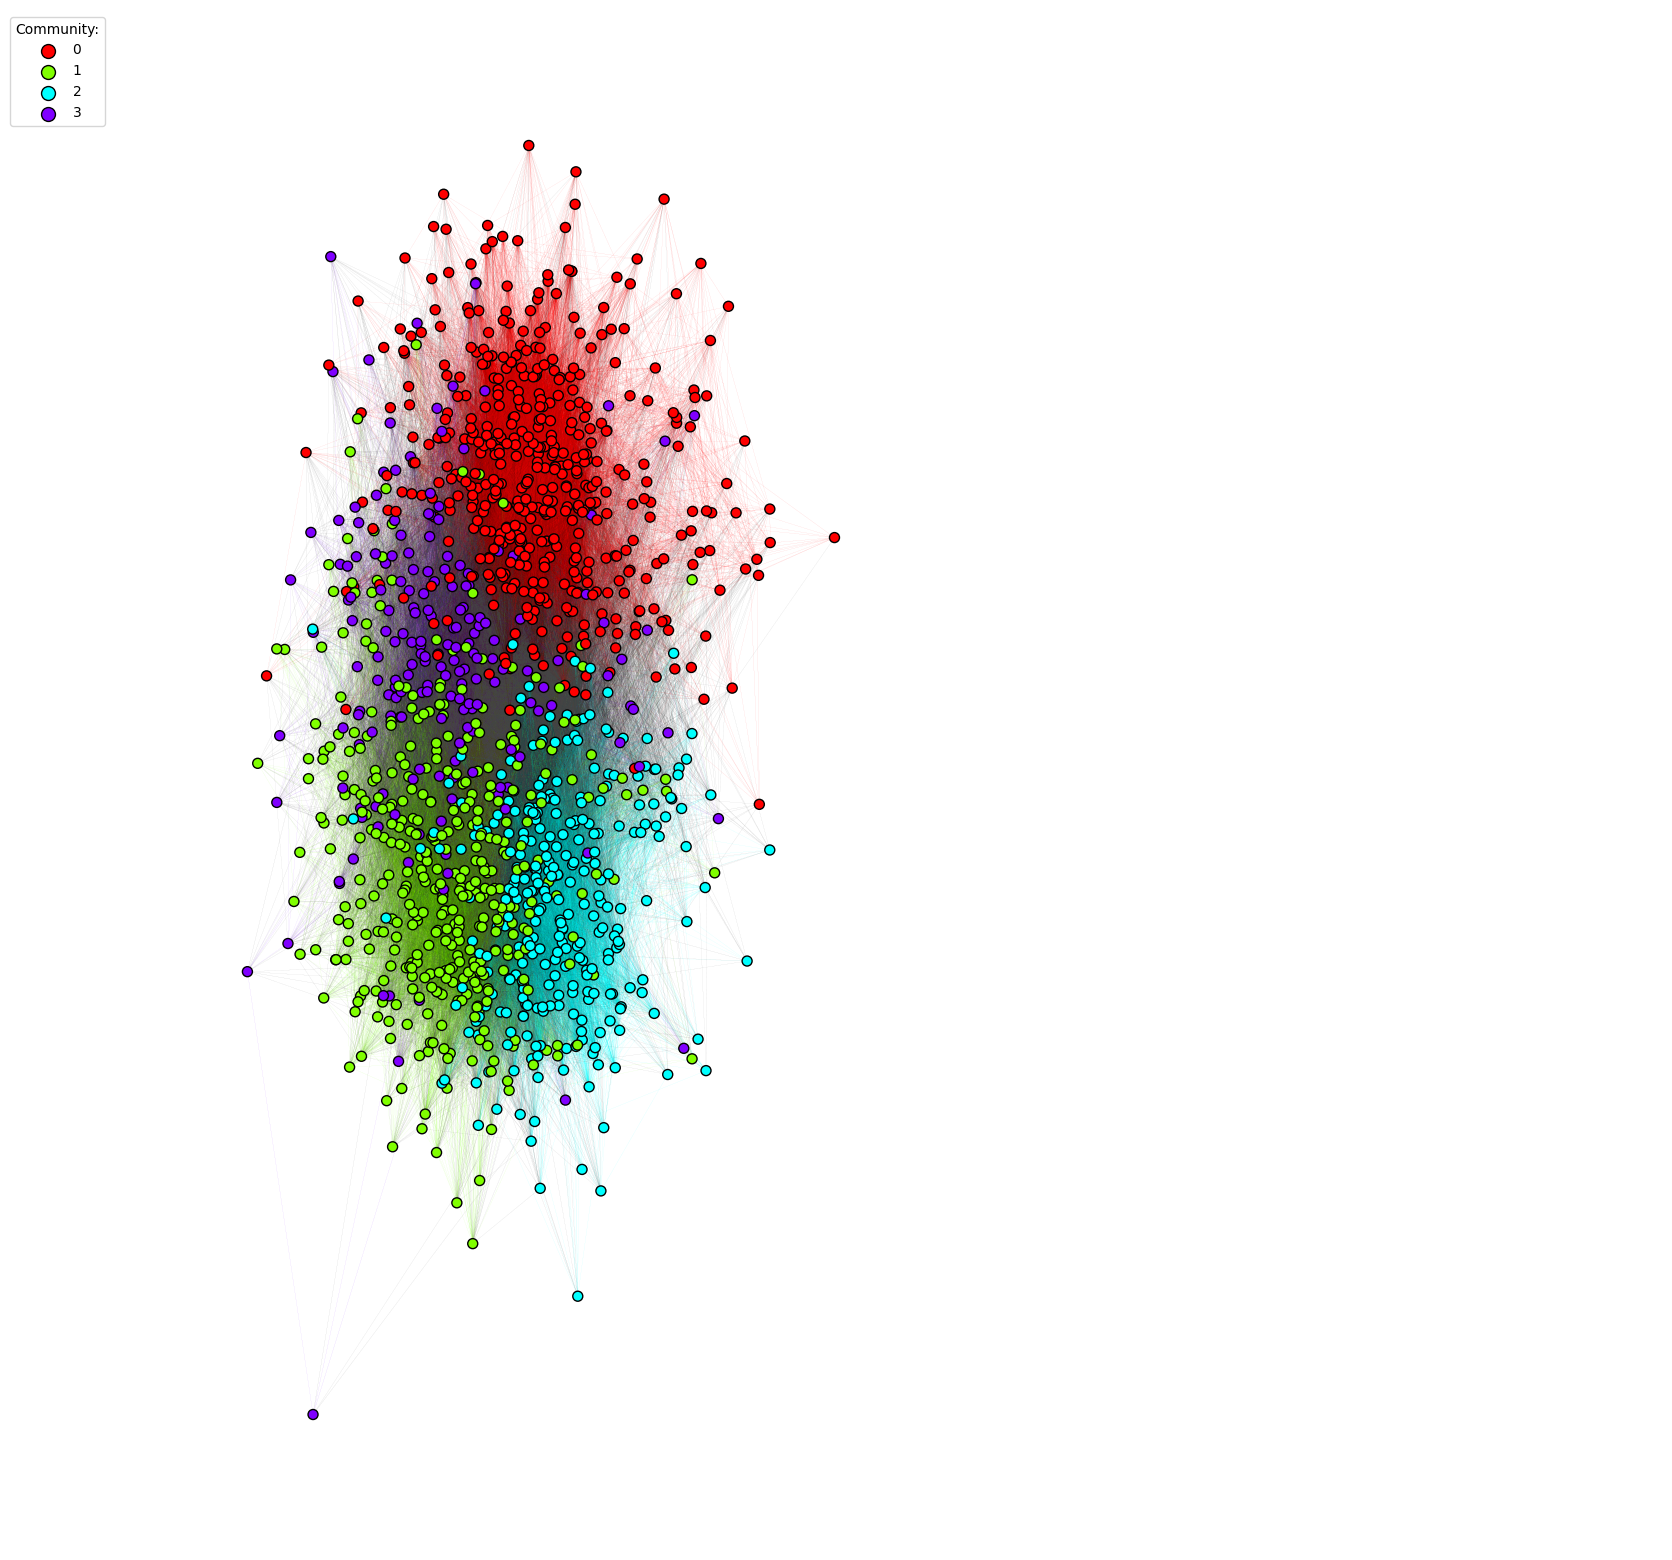

In [56]:
num_communities = len(communities)
palette = ig.RainbowPalette(n=num_communities)
for i, community in enumerate(communities):
    mygraph.vs[community]["color"] = i
    community_edges = mygraph.es.select(_within=community)
    community_edges["color"] = i

fig, ax = plt.subplots(figsize=(20, 20))
ig.plot(
    communities,
    palette=palette,
    edge_width=0.015,
    vertex_size=10,
    arrow_size=0,
    target="graph.png",
    
)

# Create a custom color legend
legend_handles = []
for i in range(num_communities):
    handle = ax.scatter(
        [], [],
        s=100,
        facecolor=palette.get(i),
        edgecolor="k",
        label=i,
    )
    legend_handles.append(handle)
ax.legend(
    handles=legend_handles,
    title='Community:',
    bbox_to_anchor=(0, 1.0),
    bbox_transform=ax.transAxes,
)

plt.show()

# 


# 


# 


# Communities car

In [36]:
cluster_list=[]
for vertex,cluster_n in zip(mygraph.vs,partition.membership):
    cluster_list.append([vertex["name"],cluster_n])

cluster_df=pd.DataFrame(cluster_list,columns=["ensb_prot_id","cluster"])

n_clusters=cluster_df["cluster"].unique()
print(n_clusters)

cluster_dict={}
for cluster in n_clusters:
    cluster_dict[cluster]=cluster_df[cluster_df["cluster"]==cluster]["ensb_prot_id"].tolist()


[0 3 1 2]


In [37]:
df=pd.DataFrame(cluster_list,columns=["ensb_prot_id","cluster"])
df.to_csv('cluster.csv',index=False)

In [43]:
# export each cluster to a file
def export_com(com_dict):
    for key in com_dict.keys():
        com=com_dict[key]
        with open(f'communities/community_{key}.txt','w') as f:
            for item in com:
                f.write(f"{item}\n")

export_com(cluster_dict)

# Read communities files

In [2]:

def read_coms():
    com_dict={}
    for i in range(4):
        com_i=[]
        with open(f'communities/community_{i}.txt','r') as f:
            for line in f:
                com_i.append(line.strip())
        com_dict[i]=com_i
    return com_dict

cluster_dict=read_coms()




{0: ['ENSG00000001617',
  'ENSG00000144355',
  'ENSG00000116544',
  'ENSG00000102924',
  'ENSG00000167680',
  'ENSG00000128683',
  'ENSG00000169840',
  'ENSG00000168758',
  'ENSG00000184144',
  'ENSG00000169855',
  'ENSG00000149571',
  'ENSG00000171587',
  'ENSG00000136535',
  'ENSG00000173482',
  'ENSG00000164885',
  'ENSG00000143590',
  'ENSG00000102081',
  'ENSG00000136750',
  'ENSG00000169783',
  'ENSG00000178403',
  'ENSG00000135638',
  'ENSG00000115844',
  'ENSG00000161681',
  'ENSG00000126259',
  'ENSG00000169992',
  'ENSG00000198576',
  'ENSG00000080224',
  'ENSG00000182771',
  'ENSG00000108947',
  'ENSG00000175745',
  'ENSG00000131711',
  'ENSG00000166342',
  'ENSG00000241360',
  'ENSG00000006468',
  'ENSG00000112902',
  'ENSG00000106852',
  'ENSG00000135333',
  'ENSG00000180613',
  'ENSG00000142949',
  'ENSG00000154134',
  'ENSG00000134121',
  'ENSG00000196358',
  'ENSG00000139352',
  'ENSG00000187323',
  'ENSG00000162631',
  'ENSG00000139910',
  'ENSG00000116106',
  'ENSG000

### Gprofile

In [3]:
def gprofiler(genes):
    gp = GProfiler(return_dataframe=True)
    gp_results = gp.profile(organism='hsapiens', query=genes)
    return gp_results

### Enrinch

In [4]:
cluster_results = {}
for cluster_id, genes in cluster_dict.items():
    cluster_results[cluster_id] = gprofiler(genes)
cluster_results = dict(sorted(cluster_results.items()))# order the results by cluster id



In [5]:
cluster_results[0].to_csv('cluster_0.csv',index=False)  

In [10]:
cluster_results[0]

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:CC,GO:0045202,synapse,1.288945e-109,True,"""The junction between an axon of one neuron an...",1468,456,198,22097,0.434211,0.134877,query_1,[GO:0030054]
1,GO:BP,GO:0007399,nervous system development,2.483765e-92,True,"""The process whose specific outcome is the pro...",2531,428,226,21031,0.528037,0.089293,query_1,[GO:0048731]
2,GO:BP,GO:0099537,trans-synaptic signaling,3.166261e-88,True,"""Cell-cell signaling in either direction acros...",756,428,136,21031,0.317757,0.179894,query_1,[GO:0099536]
3,GO:BP,GO:0099536,synaptic signaling,1.650754e-87,True,"""Cell-cell signaling to, from or within a syna...",780,428,137,21031,0.320093,0.175641,query_1,[GO:0007267]
4,GO:CC,GO:0030054,cell junction,1.730612e-86,True,"""A cellular component that forms a specialized...",2230,456,210,22097,0.460526,0.094170,query_1,[GO:0110165]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,CORUM,CORUM:6367,mGluR2-mGluR7 complex,4.999059e-02,True,mGluR2-mGluR7 complex,2,47,2,3383,0.042553,1.000000,query_1,[CORUM:0000000]
932,CORUM,CORUM:6363,mGluR2-mGluR4 complex,4.999059e-02,True,mGluR2-mGluR4 complex,2,47,2,3383,0.042553,1.000000,query_1,[CORUM:0000000]
933,CORUM,CORUM:5419,HTR1A-GPR26 complex,4.999059e-02,True,HTR1A-GPR26 complex,2,47,2,3383,0.042553,1.000000,query_1,[CORUM:0000000]
934,CORUM,CORUM:6437,GABBR1-GABBR2 complex,4.999059e-02,True,GABBR1-GABBR2 complex,2,47,2,3383,0.042553,1.000000,query_1,[CORUM:0000000]


In [18]:
def get_bp(cluster_results):
    for i in range(4):
        bp=cluster_results[i][cluster_results[i]["source"]=="GO:BP"]
        codes=bp["native"].tolist()
        with open(f'Revigo/com_{i+1}_BP_codes.txt','w') as f:
            for item in codes:
                f.write(f"{item}\n")

get_bp(cluster_results)

In [53]:
term_filter=["GO:BP","GO:CC","KEGG","REAC"]
term_filter=["GO:BP","KEGG","REAC" ]
for cluster_id, cluster_data in cluster_results.items():

    print("-"*60 + f"community {cluster_id +1}" + "-"*60)

    cluster_data = cluster_data[cluster_data["source"].isin(term_filter)]
    cluster_data=cluster_data[["source","native","name","p_value","description"]]
    cluster_data = cluster_data.sort_values(by=["source", "p_value"])

    cluster_data = cluster_data.groupby("source").head(15)

    cluster_data.reset_index(drop=True, inplace=True)

    
    display(cluster_data)
    cluster_data.to_latex(f'cluster_{cluster_id}.tex',index=False)


------------------------------------------------------------community 1------------------------------------------------------------


,source,native,name,p_value,description
0,GO:BP,GO:0007399,nervous system development,2.483765e-92,"""The process whose specific outcome is the pro..."
1,GO:BP,GO:0099537,trans-synaptic signaling,3.166261e-88,"""Cell-cell signaling in either direction acros..."
2,GO:BP,GO:0099536,synaptic signaling,1.650754e-87,"""Cell-cell signaling to, from or within a syna..."
3,GO:BP,GO:0098916,anterograde trans-synaptic signaling,2.354409e-86,"""Cell-cell signaling from pre to post-synapse,..."
4,GO:BP,GO:0007268,chemical synaptic transmission,2.354409e-86,"""The vesicular release of classical neurotrans..."
5,GO:BP,GO:0050808,synapse organization,8.411682e-80,"""A process that is carried out at the cellular..."
6,GO:BP,GO:0034330,cell junction organization,1.808187e-63,"""A process that is carried out at the cellular..."
7,GO:BP,GO:0048731,system development,1.510764e-58,"""The process whose specific outcome is the pro..."
8,GO:BP,GO:0048699,generation of neurons,2.196390e-58,"""The process in which nerve cells are generate..."
9,GO:BP,GO:0048666,neuron development,1.322635e-56,"""The process whose specific outcome is the pro..."


------------------------------------------------------------community 2------------------------------------------------------------


,source,native,name,p_value,description
0,GO:BP,GO:0070647,protein modification by small protein conjugat...,4.163089e-13,"""A protein modification process in which one o..."
1,GO:BP,GO:0036211,protein modification process,5.827909e-13,"""The covalent alteration of one or more amino ..."
2,GO:BP,GO:0009057,macromolecule catabolic process,1.994400e-12,"""The chemical reactions and pathways resulting..."
3,GO:BP,GO:0043687,post-translational protein modification,3.528978e-12,"""The process of covalently altering one or mor..."
4,GO:BP,GO:0043412,macromolecule modification,3.743761e-12,"""The covalent alteration of one or more monome..."
5,GO:BP,GO:0016567,protein ubiquitination,1.113912e-11,"""The process in which one or more ubiquitin gr..."
6,GO:BP,GO:0019538,protein metabolic process,4.261900e-11,"""The chemical reactions and pathways involving..."
7,GO:BP,GO:0032446,protein modification by small protein conjugation,1.039775e-10,"""A protein modification process in which one o..."
8,GO:BP,GO:0080090,regulation of primary metabolic process,2.617055e-10,"""Any process that modulates the frequency, rat..."
9,GO:BP,GO:0051171,regulation of nitrogen compound metabolic process,3.606973e-10,"""Any process that modulates the frequency, rat..."


------------------------------------------------------------community 3------------------------------------------------------------


,source,native,name,p_value,description
0,GO:BP,GO:0006325,chromatin organization,2.269095e-130,"""The assembly or remodeling of chromatin compo..."
1,GO:BP,GO:0071824,protein-DNA complex organization,1.826747e-128,"""Any process in which macromolecules aggregate..."
2,GO:BP,GO:0006338,chromatin remodeling,1.760418e-110,"""A dynamic process of chromatin reorganization..."
3,GO:BP,GO:0006351,DNA-templated transcription,1.185702e-101,"""The synthesis of an RNA transcript from a DNA..."
4,GO:BP,GO:0032774,RNA biosynthetic process,7.405773e-101,"""The chemical reactions and pathways resulting..."
5,GO:BP,GO:0006355,regulation of DNA-templated transcription,5.445540e-100,"""Any process that modulates the frequency, rat..."
6,GO:BP,GO:2001141,regulation of RNA biosynthetic process,1.552310e-99,"""Any process that modulates the frequency, rat..."
7,GO:BP,GO:0019219,regulation of nucleobase-containing compound m...,1.360337e-93,"""Any cellular process that modulates the frequ..."
8,GO:BP,GO:0051252,regulation of RNA metabolic process,1.751119e-93,"""Any process that modulates the frequency, rat..."
9,GO:BP,GO:0006357,regulation of transcription by RNA polymerase II,1.072404e-92,"""Any process that modulates the frequency, rat..."


------------------------------------------------------------community 4------------------------------------------------------------


,source,native,name,p_value,description
0,GO:BP,GO:0007264,small GTPase-mediated signal transduction,5.718408e-36,"""An intracellular signaling cassette in which ..."
1,GO:BP,GO:0035556,intracellular signal transduction,4.054049e-30,"""The process in which a signal is passed on to..."
2,GO:BP,GO:0141124,intracellular signaling cassette,5.241324e-30,"""An intracellular signaling module that is par..."
3,GO:BP,GO:1902531,regulation of intracellular signal transduction,6.472324e-18,"""Any process that modulates the frequency, rat..."
4,GO:BP,GO:0051056,regulation of small GTPase mediated signal tra...,7.004041e-17,"""Any process that modulates the frequency, rat..."
5,GO:BP,GO:0007165,signal transduction,4.088609e-14,"""The cellular process in which a signal is con..."
6,GO:BP,GO:0007154,cell communication,4.852058e-14,"""Any process that mediates interactions betwee..."
7,GO:BP,GO:0023052,signaling,4.161277e-13,"""The entirety of a process in which informatio..."
8,GO:BP,GO:0023051,regulation of signaling,2.180838e-12,"""Any process that modulates the frequency, rat..."
9,GO:BP,GO:0010646,regulation of cell communication,2.426281e-12,"""Any process that modulates the frequency, rat..."
